# <center>VMAT TPS Import </center>

### PortPy can generate DICOM RT plan for PortPy plans that can can be imported to Treatment Planning System (TPS). This compatibility enables users to import the PortPy plan into the FDA-approved TPS system for a final clinical evaluation. This example outlines the following steps:


1. Creating a simple IMRT plan (Plan class, Optimization class)

2. Perform leaf sequencing in Portpy for IMRT plan and generate dicom RT plan file which can be imported to FDA approved TPS (Utils class)

3. Importing the PortPy plan into the TPS system for final dose calculation

4. Exporting the finally calculated dose from the TPS (Eclipse) system (in DICOM RT-Dose format) into PortPy (Utils class)

5. Comparing the PortPy plan against the TPS plan for validation and analysis 


In [1]:
import sys
sys.path.append('..')

In [8]:
import portpy.photon as pp
import os
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
import pandas as pd

### 1) Creating a simple IMRT plan (Plan class, Optimization class)


In [3]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)

# pick a patient from the existing patient list to get detailed info (e.g., beam angles, structures).
data.patient_id = 'Lung_Patient_3'
# # display the data of the patient in console or browser.
# data.display_patient_metadata()

In [9]:

# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

# Select beam ids based upon target location. We select beam ids from 0 to 36 based upon beams metadata
beam_ids = np.arange(0, 37) #  users can modify this based upon their beam selection
beams = pp.Beams(data, beam_ids=beam_ids)

# load clinical criteria from the config files for which plan to be optimized
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# Loading hyper-parameter values for optimization problem
protocol_name = 'Lung_2Gy_30Fx_vmat'
vmat_opt_params = data.load_config_opt_params(protocol_name=protocol_name)

# # Creating optimization structures (i.e., Rinds, PTV-GTV)
structs.create_opt_structures(opt_params=vmat_opt_params,
                              clinical_criteria=clinical_criteria)

# Loading influence matrix
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# Assign discrete beam/control_point_ids to arcs and create arcs dictionary.
# Below is an example of creating 2 arcs. Users can create single or multiple arcs.
arcs_dict = {'arcs': [{'arc_id': "01", "beam_ids": beam_ids[0:int(len(beam_ids) / 2)]},
                      {'arc_id': "02", "beam_ids": beam_ids[int(len(beam_ids) / 2):]}]}
# Create an object of Arcs class
arcs = pp.Arcs(arcs_dict=arcs_dict, inf_matrix=inf_matrix)

# Create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria, arcs=arcs)

Creating optimization structures.. It may take some time due to dilation
Optimization structures created!!
Creating BEV..
Loading sparse influence matrix...
Done


#### Optimize VMAT plan using sequential convex programming

In [ ]:
# Initialize Optimization
vmat_opt = pp.VmatScpOptimization(my_plan=my_plan,
                                  opt_params=vmat_opt_params)
# Run Sequential convex algorithm for optimising the plan.
# The final result will be stored in sol and convergence will store the convergence history (i.e., results of each iteration)
sol, convergence = vmat_opt.run_sequential_cvx_algo(solver='MOSEK', verbose=True)

# Visualize convergence. The convergence dataframe contains the following columns:
df = pd.DataFrame(convergence, columns=['outer_iteration', 'inner_iteration', 'step_size_f_b', 'forward_backward', 'intermediate_obj_value', 'actual_obj_value', 'accept'])
# We can, for example, plot the actual and intermediate objective values against the outer iteration
df.plot(x='outer_iteration', y=['actual_obj_value', 'intermediate_obj_value'])
plt.show()

### 2) Generate dicom RT plan file (Utils class)


1. Create dicom RT Plan file which can be imported in FDA-aprooved TPS

2. Import the patient's data into the TPS system. This includes CT images and RT structures that are not included in the PortPy dataset and need to be downloaded from the [TCIA website](https://www.cancerimagingarchive.net/access-data/). The user can obtain the *TCIA collection ID* and *TCIA subject ID* using *get_tcia_metadata()* method in PortPy. Along with the above patient's data, import RT plan dicom to TPS 

3. Finally, in TPS, execute final dose calculation.


In [4]:
my_plan = pp.load_plan(plan_name='my_plan_vmat.pkl', path=os.path.join(r'C:\temp', data.patient_id))
sol = pp.load_optimal_sol(sol_name='sol_vmat.pkl', path=os.path.join(r'C:\temp', data.patient_id))

In [ ]:
# create dicom RT Plan file to be imported in TPS
out_rt_plan_file = r'C:\Temp\Lung_Patient_3\rt_plan_portpy_vmat.dcm'  # change this file directory based upon your needs
in_rt_plan_file = r'C:\Temp\Lung_Patient_3\rt_plan_echo_vmat.dcm'  # change this directory as per your
pp.write_rt_plan_vmat(my_plan=my_plan, in_rt_plan_file=in_rt_plan_file, out_rt_plan_file=out_rt_plan_file)

In [7]:
# get the corresponding tcia collection/subject ID
data.get_tcia_metadata()

{'portpy_patient_id': 'Lung_Patient_6', 'subject_id': 'LUNG1-007', 'collection_id': 'NSCLC-Radiomics'}


### 3) Exporting the finally calculated dose from the TPS system into PortPy
After the final dose calculation in Eclipse, export the dose in DICOM RT-Dose format using the Eclipse Export module. Then, utilize the following lines of code to convert the exported dose into the PortPy format for visualization or evaluation purposes

In [10]:
# Specify the location and name of the DICOM RT Dose file
dose_file_name = os.path.join(r'C:\temp', data.patient_id, 'rt_dose_portpy_vmat.dcm')  
# Convert the DICOM dose into PortPy format
ecl_dose_3d = pp.convert_dose_rt_dicom_to_portpy(my_plan=my_plan, dose_file_name=dose_file_name)
ecl_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=ecl_dose_3d)

### 4)  Comparing the PortPy VMAT plan against the TPS plan for validation and analysis 

Finally dose exported from TPS in RT-dose DICOM file can be compared against PortPy dose using full influence matrix


In [12]:
beams_full = pp.Beams(data, beam_ids=beam_ids, load_inf_matrix_full=True)
# load influence matrix based upon beams and structure set
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
dose_full_1d = inf_matrix_full.A @ (sol['optimal_intensity'] * my_plan.get_num_of_fractions())  # calculate dose using full matrix

Creating BEV..
Loading full influence matrix..
Done


Skipping Structure HEART as it is not within calculation box.
Skipping Structure HEART as it is not within calculation box.


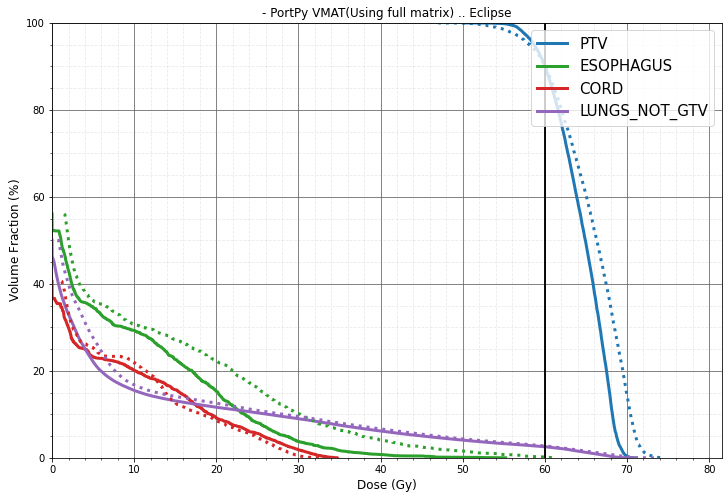

In [13]:
# Visualize the DVH discrepancy between eclipse dose and dose using full matrix in portpy
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNGS_NOT_GTV']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_full_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- PortPy VMAT(Using full matrix) .. Eclipse')
plt.show()